In [1]:
import os
import sounddevice as sd
import numpy as np
from matplotlib import pyplot as plt

# modules from this software
import stimulus as stim
import _parseargs as parse
import utils as utils
import sys
import soundfile as sf
import librosa

In [ ]:
recording='../recordings/REcbdb0b438839daebf0f87bb84af9d989_sigtest_fs16000_ss3_es1/sigtest_fs16000_ss3_es1_nokia_recording.wav'
original='../recordings/REcbdb0b438839daebf0f87bb84af9d989_sigtest_fs16000_ss3_es1/sigtest_fs16000_ss3_es1.wav'
sys.argv = 'measure.py --fs 16000 -ss 3 -es 1'.split()

In [2]:
def replace_extension(filename, new_extension):
    # Split the filename into name and extension
    name, ext = os.path.splitext(filename)
    # Concatenate the name with the new extension
    new_filename = name + new_extension
    return new_filename

In [3]:
def compute_tdecay(impulse_response_ori, sample_rate, DBdecay, plot=False, title=''):
    
    max_position = np.argmax(impulse_response_ori)

    
    impulse_response = impulse_response_ori[max_position:, :]
    # Step 1: Calculate the energy of the impulse response
    energy = impulse_response ** 2

    # Step 2: Compute the cumulative sum in reverse
    cumulative_energy = np.cumsum(energy[::-1])[::-1]

    # Step 3: Convert the cumulative sum to a decay curve in dB
    decay_curve = 10 * np.log10(cumulative_energy / np.max(cumulative_energy))

    # Step 4: Find the time point where the decay curve crosses -Tdecay dB
    t_Tdecay_point = np.where(decay_curve <= -DBdecay)[0]

    if len(t_Tdecay_point) == 0:
        print("Warning: The decay curve does not reach -Tdecay dB")
        return None

    # Step 5: Interpolate to get a more accurate TTdecay
    index_Tdecay = t_Tdecay_point[0]

    # Calculate the exact point with linear interpolation
    if index_Tdecay > 0:
        t1 = index_Tdecay - 1
        t2 = index_Tdecay
        y1 = decay_curve[t1]
        y2 = decay_curve[t2]
        t_Tdecay = t1 + (y1 + DBdecay) / (y1 - y2)
    else:
        t_Tdecay = index_Tdecay

    # Convert samples to time
    TTdecay = t_Tdecay / sample_rate
    print(f"Reverberation time (T{DBdecay}) is {TTdecay} seconds")

    TTdecay_sample = int(TTdecay * fs)
    RIRtrimmed = impulse_response_ori.copy()
    RIRtrimmed = RIRtrimmed[max_position-TTdecay_sample:max_position+TTdecay_sample,:]
    RIRtrimmed0 = impulse_response_ori.copy()
    RIRtrimmed0[0:max_position-TTdecay_sample,:] = 0
    RIRtrimmed0[max_position+TTdecay_sample:,:] = 0


    if plot:
        fig = plt.figure(figsize = (9,3))
        t = np.arange(0, impulse_response.shape[0]) / fs
        plt.plot(t, decay_curve)
        plt.grid()
        plt.xlabel('Time (s)')
        plt.ylabel('Decay curve (dB)')
        plt.axhline(y=-DBdecay, color='r', linestyle='--', label=f'-{DBdecay} dB')
        plt.legend()
        plt.title(title)
        plt.show()


    return TTdecay, decay_curve, RIRtrimmed, RIRtrimmed0

In [5]:
flag_defaultsInitialized = parse._checkdefaults()
args = parse._parse()
parse._defaults(args)
# Create a test signal object, and generate the excitation
testStimulus = stim.stimulus('sinesweep', args.fs);
testStimulus.generate(args.fs, args.duration, args.amplitude,args.reps,args.startsilence, args.endsilence, args.sweeprange)

In [6]:
# Load recorded signal
x, fs = librosa.load(recording, sr=args.fs)
x = np.expand_dims(x, 1)
x.shape

(219200, 1)

In [7]:
# Deconvolve
impulse_response = testStimulus.deconvolve(x)

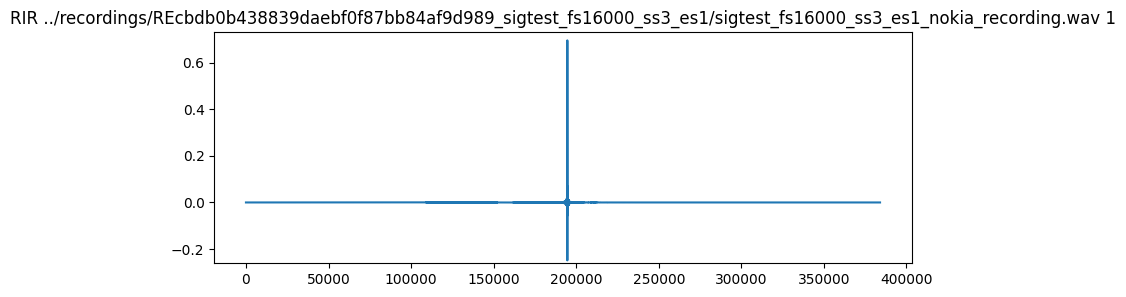

In [8]:
maxval = np.max(impulse_response)
minval = np.min(impulse_response)
taxis = np.arange(0,impulse_response.shape[0]/fs,1/fs)

# Plot all on a single figure
# plt.figure(figsize = (10,6))
# plt.plot(taxis,RIR)
# plt.ylim((minval+0.05*minval,maxval+0.05*maxval))

# Plot them as subplots
numplots = impulse_response.shape[1]
#height = numplots*3
#fig = plt.figure(figsize = (10,height))
for idx in range(numplots):
    fig = plt.figure(figsize = (9,3))
    plt.plot(impulse_response[:,idx])
    plt.ylim((minval+0.05*minval,maxval+0.05*maxval))
    plt.title(f'RIR {recording} '+ str(idx + 1))
    #ax = fig.add_subplot(numplots,1,idx+1)
    #plt.plot(taxis,RIR[:,idx])

In [9]:
output_RIR = replace_extension(recording, '_RIR.wav')
sf.write(output_RIR, impulse_response, fs)

# Reverberation time T60

Reverberation time (T60) is 2.032620567619915 seconds


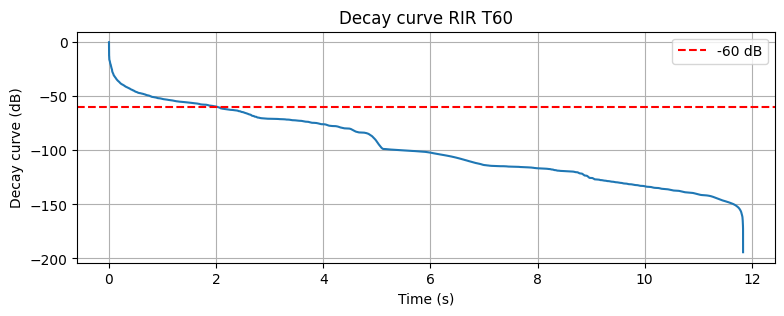

In [10]:
T60, decay_curve_T60, RIRtrimmed_T60, RIRtrimmed0_T60 = compute_tdecay(impulse_response, fs, 60, plot=True, title='Decay curve RIR T60')

In [11]:
output_RIR_trimmed_T60 = replace_extension(recording, '_RIR_trimmed_T60.wav')
output_RIR_trimmed0_T60 = replace_extension(recording, '_RIR_trimmed0_T60.wav')

sf.write(output_RIR_trimmed_T60, RIRtrimmed_T60, fs)
sf.write(output_RIR_trimmed0_T60, RIRtrimmed0_T60, fs)

Reverberation time (T30) is 0.08553050919882964 seconds


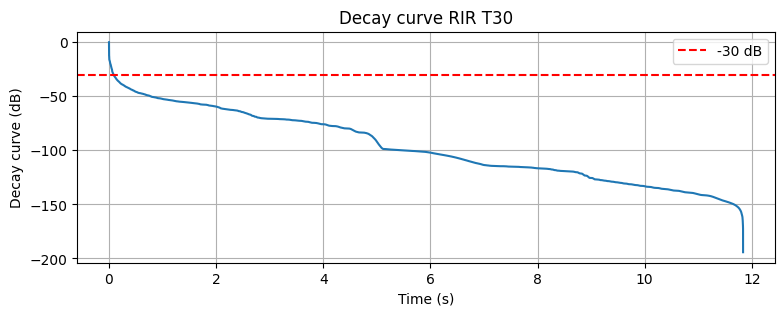

In [12]:
T30, decay_curve_T30, RIRtrimmed_T30, RIRtrimmed0_T30 = compute_tdecay(impulse_response, fs, 30, plot=True, title='Decay curve RIR T30')

In [13]:
output_RIR_trimmed_T30 = replace_extension(recording, '_RIR_trimmed_T30.wav')
output_RIR_trimmed0_T30 = replace_extension(recording, '_RIR_trimmed0_T30.wav')

sf.write(output_RIR_trimmed_T30, RIRtrimmed_T30, fs)
sf.write(output_RIR_trimmed0_T30, RIRtrimmed0_T30, fs)

In [14]:
x_original, fs = librosa.load('../sample_1min.wav', sr=args.fs)
y_simulated = np.convolve(impulse_response[:,0], x_original)
sf.write('simulated.wav', y_simulated, fs)

y_simulated_trimmed_T60 = np.convolve(RIRtrimmed_T60[:,0], x_original)
sf.write('simulated_trimmed_T60.wav', y_simulated_trimmed_T60, fs)

y_simulated_trimmed0_T60 = np.convolve(RIRtrimmed0_T60[:,0], x_original)
sf.write('simulated_trimmed0_T60.wav', y_simulated_trimmed0_T60, fs)


y_simulated_trimmed_T30 = np.convolve(RIRtrimmed_T30[:,0], x_original)
sf.write('simulated_trimmed_T30.wav', y_simulated_trimmed_T30, fs)

y_simulated_trimmed0_T30 = np.convolve(RIRtrimmed0_T30[:,0], x_original)
sf.write('simulated_trimmed0_T30.wav', y_simulated_trimmed0_T30, fs)
